In [1]:
#first some imports
import torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

import collections
import argparse
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro.infer import Importance
from pyro.infer.abstract_infer import *

from search_inference import factor, Search, memoize, HashingMarginal, BestFirstSearch

def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))
#     return lambda *args: HashingMarginal(Importance(fn, num_samples=10).run(*args))


In [2]:
#This is the world prior
# John could either be a whale or a person.
categories = ["whale", "person"]

# It is extremely unlikely that John is actually a whale.
def categoriesPrior():
    return categories[pyro.sample("category", dist.Categorical(probs=torch.tensor([0.01, 0.99])))]

# The speaker could either say "John is a whale" or "John is a person."
utterances = ["whale", "person"]

# The utterances are equally costly.
def utterancePrior():
    probs = torch.ones(len(utterances)) /len(utterances)
    return utterances[pyro.sample("utterance", dist.Categorical(probs=probs))]

# Speaker's possible goals are to communicate feature 1, 2, or 3
goals = ["large", "graceful", "majestic"]

# Prior probability of speaker's goal is set to uniform but can
# change with context/QUD.
def goalPrior():
    probs = torch.ones(len(goals)) / len(goals)
    return  goals[pyro.sample("goal", dist.Categorical(probs=probs))]

# Related features with the world:
# The features of John being considered are "large", "graceful",
# "majestic." Features are binary.
large = 1
graceful= 1
majestic = 1

featureSets = [
  {"large" : 1, "graceful" : 1, "majestic" : 1},
  {"large" : 1, "graceful" : 1, "majestic" : 0},
  {"large" : 1, "graceful" : 0, "majestic" : 1},
  {"large" : 1, "graceful" : 0, "majestic" : 0},
  {"large" : 0, "graceful" : 1, "majestic" : 1},
  {"large" : 0, "graceful" : 1, "majestic" : 0},
  {"large" : 0, "graceful" : 0, "majestic" : 1},
  {"large" : 0, "graceful" : 0, "majestic" : 0}
]

# information about feature priors (probabilistic world knowledge)
# obtained by an experimental study (see paper)
def featureSetPrior(category):
    if category == "whale":
        smp = pyro.sample("feature", dist.Categorical(probs=torch.tensor([0.30592786494628, 0.138078454222818,
                                      0.179114768847673, 0.13098781834847,
                                      0.0947267162507846, 0.0531420411185539,
                                      0.0601520520596695, 0.0378702842057509])))
        return featureSets[smp]
    if category == "person":
        smp = pyro.sample("feature", dist.Categorical(probs=torch.tensor([0.11687632453038, 0.105787535267869,
                                       0.11568145784997, 0.130847056136141,
                                       0.15288225956497, 0.128098151176801,
                                       0.114694702836614, 0.135132512637255])))
        return featureSets[smp]
    return True

# Speaker optimality parameter
alpha = 3.

# Check if interpreted category is identical to utterance
def literalInterpretation(utterance, category):
    return utterance == category

# Check if goal is satisfied
def goalState(goal, featureSet):
    if goal == "large": 
        return featureSet["large"]
    if goal == "graceful": 
        return featureSet["graceful"]
    if goal == "majestic": 
        return featureSet["majestic"]
    return True


In [3]:
@Marginal
def project(dist, qud):
    v = pyro.sample("proj", dist)
    factor("listener", alpha * dist.log_prob(qud).exp().item())
    return featureSets[qud]

@Marginal
def literal_listener(utterance, goal):
    category = categoriesPrior()
    featureSet = featureSetPrior(category)
    factor("literal_meaning", 0. if literalInterpretation(utterance, category) else -999999.)
    return goalState(goal, featureSet)

@Marginal
def speaker(large, graceful, majestic, goal):
    alpha = 3
    utterance = utterancePrior()
    literal_marginal = literal_listener(utterance, goal)
    qud = goalState(goal, {"large" : large, "graceful" : graceful, "majestic" : majestic})
    factor("listener", alpha * literal_marginal.log_prob(qud))
#     pyro.sample("listener", literal_marginal)        
    return utterance

# #     with poutine.scale(scale=torch.tensor(alpha)):
#         utterance = utterancePrior()
#         literal_marginal = literal_listener(utterance, goal)
# #         projection_posterior = Importance(literal_listener, num_samples=100)
# #         literal_marginal = HashingMarginal(projection_posterior.run(utterance, goal), sites=["literal_meaning"])
# #         literal_listener_goal_prob = project(literal_marginal, goalState(goal, {"large" : large, "graceful" : graceful, "majestic" : majestic}))
# #         print("lles: " + str(literal_listener_goal_prob.enumerate_support()))
# #         data = [literal_listener_goal_prob.log_prob(s).exp().item() for s in literal_listener_goal_prob.enumerate_support()]
# #         print("lld: " + str(data))
# #         gs = goalState(goal, {"large" : large, "graceful" : graceful, "majestic" : majestic})
#         factor("listener", alpha * literal_marginal.log_prob(qud).exp().item())
#         pyro.sample("listener", literal_listener_goal_prob)        
#     return utterance

@Marginal
def pragmatic_listener(utterance):
    category = categoriesPrior()
    featureSet = featureSetPrior(category)
    large = featureSet["large"]
    graceful = featureSet["graceful"]
    majestic = featureSet["majestic"]
    goal = goalPrior()
#     posterior = Importance(speaker, num_samples=100)
#     speaker_marginal = HashingMarginal(posterior.run(large, graceful, majestic, goal), sites=["listener"])
    speaker_marginal = speaker(large, graceful, majestic, goal)
#     print("ses: " + str(speaker_marginal.enumerate_support()))
#     data = [speaker_marginal.log_prob(s).exp().item() for s in speaker_marginal.enumerate_support()]
#     print("sd: " + str(data))

    factor("speaker", speaker_marginal.log_prob(utterance))
#     pyro.sample("speaker", speaker_marginal, obs=utterance)
    return (category, large, graceful, majestic)

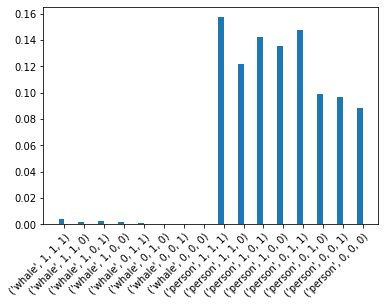

In [4]:
pragmatic_listener_marginal = pragmatic_listener("whale")

def plot_dist(d):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = list(map(str, support))

    ax = plt.subplot(111)
    width = 0.3
    bins = [x-width/2 for x in range(1, len(data) + 1)]
    ax.bar(bins,data,width=width)
    ax.set_xticks(list(range(1, len(data) + 1)))
    ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")
    
plot_dist(pragmatic_listener_marginal)  